# Development: Building Standalone Training Samples
Within new architecture, training samples will be built on the fly from standalone image "chips". These chips, however, will be precreated, static files that are stored separately from the source imagery and ground-truth from which they are derived. Simultaneously, the relevant features of every single chip will be stored in a catalog (csv/dataframe).

Author: Peter Kerins  
Date: 25 January 2019  

In [1]:
#imports
import os, sys
import shapely
import cartopy
import numpy as np
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import descarteslabs as dl
import pandas as pd
import subprocess

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
sys.path.append(ULU_REPO)
print(sys.path)
import util_vectors
import util_rasters
import util_chips

['/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python36.zip', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/lib-dynload', '', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Taufiq.Rashid/UrbanLandUse/utils', '/home/Taufiq.Rashid/UrbanLandUse']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/phase_iv/'
data_path=data_root+place+'/'

tile_resolution = 5
tile_size = 256
tile_pad = 32

processing_level = None
source = 's2'
image_suffixes = ['ZZ']
                #['E','F','G','H','Q','R','S','T','U','V','W']

s2_bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=tile_resolution  # Lx:15 S2:10

#s1_bands=['vv','vh']; s1_suffix='VVVH'  

resampling='bilinear'

label_suffix = 'aue'
label_lot = '0'

### Load and inspect study area 

sitapur Sitapur
>>> ogrinfo -al -so /data/phase_iv/sitapur/Sitapur_studyArea.shp
b'INFO: Open of `/data/phase_iv/sitapur/Sitapur_studyArea.shp\'\n      using driver `ESRI Shapefile\' successful.\n\nLayer name: Sitapur_studyArea\nMetadata:\n  DBF_DATE_LAST_UPDATE=2016-07-18\nGeometry: Polygon\nFeature Count: 1\nExtent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)\nLayer SRS WKT:\nPROJCS["WGS 84 / UTM zone 44N",\n    GEOGCS["WGS 84",\n        DATUM["WGS_1984",\n            SPHEROID["WGS 84",6378137,298.257223563,\n                AUTHORITY["EPSG","7030"]],\n            AUTHORITY["EPSG","6326"]],\n        PRIMEM["Greenwich",0,\n            AUTHORITY["EPSG","8901"]],\n        UNIT["degree",0.0174532925199433,\n            AUTHORITY["EPSG","9122"]],\n        AUTHORITY["EPSG","4326"]],\n    PROJECTION["Transverse_Mercator"],\n    PARAMETER["latitude_of_origin",0],\n    PARAMETER["central_meridian",81],\n    PARAMETER["scale_factor",0.9996],\n    PARAMETER["false_easting"

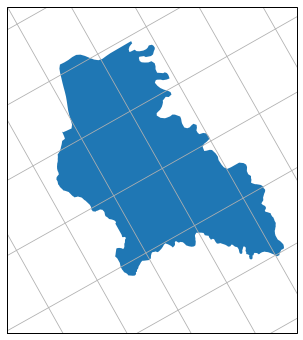

In [3]:
print(place, place.title()) # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
# print(polygon)
# pprint(shape)
place_bbox = shape['bbox']
# print(bbox)

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print("center co-ordinates", clat, clon)
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 587
dict_keys(['geometry', 'type', 'properties'])
tile022 {
  'coordinates': [[[80.54417672689733, 27.654738923241645], [80.56039780033113, 27.6547913102528], [80.56034001206851, 27.669235266940337], [80.54411680645714, 27.669182847947447], [80.54417672689733, 27.654738923241645]]],
  'type': 'Polygon'
}


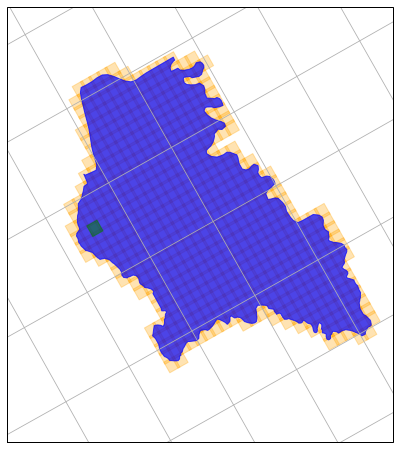

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

In [5]:
# select city
# loop through ground truth tiles
# for each tile:
# get locations of target pixels
# loop through list of locations of target pixels
# for each pixel:
# grab a window of imagery centered around target pixel
# save this as a separate "image chip" geotiff, with careful naming
# as each chip is saved, add an entry to a catalog dataframe
# save dataframe

In [6]:

for image_suffix in image_suffixes:
    util_chips.generate_chips(data_root, place, tiles,
        label_suffix, label_lot,
        source, image_suffix, s2_bands,
        resampling=resampling, processing_level=processing_level,
        chip_radius=32,
        remove_duplicates=True,
        category_label={0:'Open Space',1:'Non-Residential',\
           2:'Residential Atomistic',3:'Residential Informal Subdivision',\
           4:'Residential Formal Subdivision',5:'Residential Housing Project',\
           6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'},
        show_stats=False,
        tile_start=None,
        tile_stop=None)

sitapur ZZ: valid pixels in tile0176: 1037
sitapur ZZ: valid pixels in tile0205: 18891


KeyboardInterrupt: 

In [7]:
df = util_chips.load_catalog()

In [8]:
df

,path,city,gt_type,gt_lot,locale,source,image,bands,resolution,resampling,processing,tile_id,x,y,lulc
0,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,255,171,0
1,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,253,172,0
2,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,254,172,0
3,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,255,172,0
4,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,251,173,1
5,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,252,173,0
6,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,253,173,0
7,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,254,173,0
8,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,255,173,0
9,/data/phase_iv/sitapur/chips/none/sitapur_aue0...,sitapur,aue,0,43,s2,E,"['blue', 'green', 'red', 'nir', 'swir1', 'swir...",5,bilinear,none,176,250,174,1
